In [1]:
import abtem
import matplotlib.pyplot as plt
import numpy as np
from abtem.waves.transfer import polar_symbols
from ase.build import mx2
from ase.io import read
from mpl_toolkits.axes_grid1 import ImageGrid

abtem.config.set({"local_diagnostics.progress_bar": False});

In [2]:
coefficients = tuple(symbol for symbol in polar_symbols if symbol[0] == "C")


def make_psf(aberration):
    psf = (
        abtem.Probe(
            energy=150e3, semiangle_cutoff=30, gpts=(512, 512), extent=50, **aberration
        )
        .build()
        .phase_shift(np.pi / 2)
        .complex_images()
        .crop(extent=(15, 15), offset=(17.5, 17.5))
        .compute()
    )
    return psf  # * 4e4


def make_coefficient_plot(func, coefficients):
    orders = [int(c[1]) for c in coefficients]
    cols = [x - 1 for x in orders]
    rows = [j for i in range(1, max(orders) + 1) for j in range(orders.count(i))]
    aberrations = [
        {coefficient: 50 ** order} for coefficient, order in zip(coefficients, orders)
    ]
    images = [func(aberration) for aberration in aberrations]

    nrows, ncols = (4, 5)
    fig = plt.figure(1, figsize=(14, 14))
    axes = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), **{"axes_pad": 0.05},)

    for ax in axes:
        ax.set_axis_off()

    for image, row, col, coefficient, order in zip(
        images, rows, cols, coefficients, orders
    ):
        i = np.ravel_multi_index((row, col), (nrows, ncols))
        axes[i].annotate(f"{coefficient}", xy=(0.15, 0.25), color="w", size=16)

        vmin = np.abs(image.array).min() + np.abs(image.array).ptp() * 0.2
        vmax = np.abs(image.array).max() + np.abs(image.array).ptp() * 0.07

        image.show(
            ax=axes[i], complex_coloring_kwargs={"saturation": 2}, vmin=vmin, vmax=vmax
        )

    left_corner = np.ravel_multi_index((nrows - 1, 0), (nrows, ncols))
    func({}).show(ax=axes[left_corner])
    axes[left_corner].annotate(f"Source", xy=(0.15, 0.25), color="w", size=16)

(getting_started:user_guide:contrast_transfer_function)=
# Contrast Transfer Function
The [Contrast Transfer Function](https://en.wikipedia.org/wiki/Contrast_transfer_function) (CTF) describes the aberrations of the objective lens in HRTEM and specifies how the condenser system shapes the probe in STEM. Here we describe how to create a CTF with specific aberrations and how this affects the resulting images.

## Phase aberrations
Ideally, a lens forms a spherical wave converging on or emerging from a single point. In practice, aberrations cause the wave front to deviate from a spherical surface. In a polar representation, this deviation, or phase error, can be written as $\chi(k, \phi)$, where $k = \sqrt{k_x^2 + k_y^2}$ is the radial component and $\phi$ is the azimuthal component. We expand the phase error as a series expansion

$$ 
    \chi(k, \phi) = \frac{2 \pi}{\lambda} \sum_{n,m} \frac{1}{n + 1} C_{n,m} (k \lambda)^{n+1} \cos\left[m (\phi - \phi_{n,m}) \right] \quad ,
$$

where $n$ and $m$ is the radial and azimuthal order, respectively.

```{note}
`abTEM` exclusively uses polar expansion coefficients; however, a conversion utility from the Cartesian to the polar representation is available in `abtem.waves.transfer.cartesian2polar`.
```

If the microscope is well aligned then off-axis aberrations (astigmatisms and comas) are small and the phase error is dominated by the first two isotropic terms

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f = -C_{1,1}$ is the defocus and $C_s=C_{3,3}$ is the third order spherical aberration.

The `CTF` object takes parameters of the form `Cnm` and `phinm`, and some may also be given using their common aliases, e.g. `defocus = -C10` **(Note the negative sign in this definition)**. The expansion is implemented up to 5th order and all the coefficients keyword are given in the table below.

```{list-table}
:header-rows: 1

* - 1st order
  - 2nd order
  - 3rd order
  - 4th order
  - 5th order
* - `C10`
  - `C21`, `phi21`
  - `C30`
  - `C41`, `phi41`
  - `C50`
* - `C12`, `phi12`
  - `C23`, `phi23`
  - `C32`, `phi32`
  - `C43`, `phi43`
  - `C52`, `phi52`
* - 
  - 
  - `C34`, `phi34`
  - `C45`, `phi45`
  - `C54`, `phi54`
* - 
  -
  -
  -
  - `C56`, `phi56`
```



### Point spread function

We can visualize each phase aberration by showing its effect on a small probe wave function. This is called the point spread function (PSF) and describes the response of an imaging system to a point source. In the grid below, the indicated aberration is applied to the probe shown in the bottom left. Both magnitude and phase is indicated through domain coloring, see appendix. The magnitude of the coefficients are given according to $C_{nm} = 70 ^n \ \mathrm{Å}$, i.e. the high-order coefficients has a much larger magnitude.

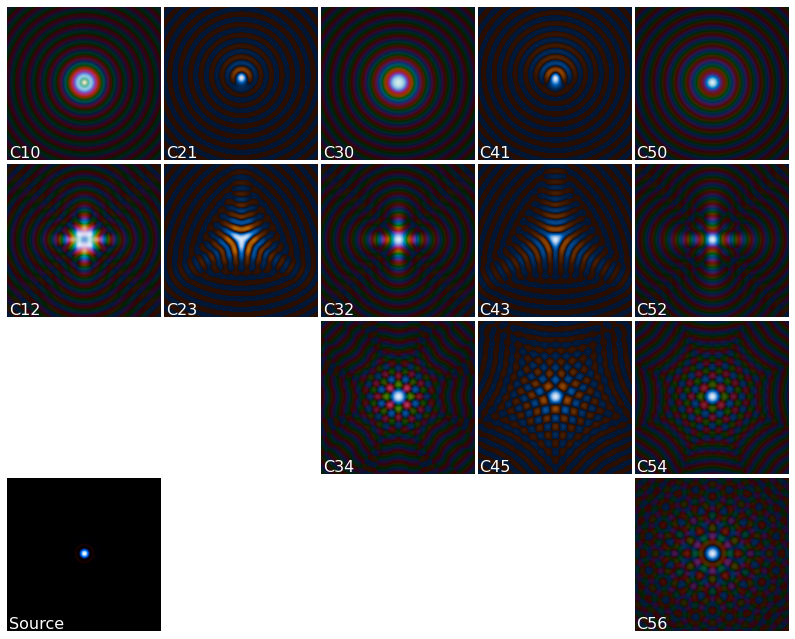

In [3]:
make_coefficient_plot(make_psf, coefficients)

### Applying phase aberrations to wave functions
Given the exit wave function $\phi_{exit}$ and an objective lens with a phase error $\chi$ (and infinite aperture), the wave function at the image plane is given by

$$  
    \psi_{image}(k, \phi) = \psi_{exit}(k, \phi) \exp(-i \chi(k, \phi)) \quad .
$$ (eq:user_guide:walkthrough:contrast_transfer_function:apply_ctf)

We first otain an exit wave function for a plane wave at $200 \ \mathrm{keV}$ given the STO/LTO interface created here.

In [4]:
atoms = abtem.orthogonalize_cell(mx2(vacuum=2))

exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.02).multislice(atoms)

We create a compatible `CTF` for electrons with an energy of $80 \ \mathrm{keV}$. The spherical aberration will be set to $-20~\mu \mathrm{m}$ (remember that abTEM uses units of Å) and the defocus is set to the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy) (here $-111.92 \ \mathrm{Å}$).

In [5]:
Cs = -20e-6 * 1e10  # 30 microns

ctf = abtem.CTF(Cs=Cs, energy=80e3)
ctf.defocus = ctf.scherzer_defocus

print(f"defocus = {ctf.defocus:.2f} Å")

defocus = -111.92 Å


We aberrations may also be given as a dictionary.

In [6]:
aberrations = {"C10": -ctf.defocus, "C30": Cs}

ctf = abtem.CTF(aberrations=aberrations, energy=ctf.energy)

We can get radial `LineProfiles` up to a given angle to preview the CTF. We show *by convention* the imaginary part of complex exponential of the phase error.

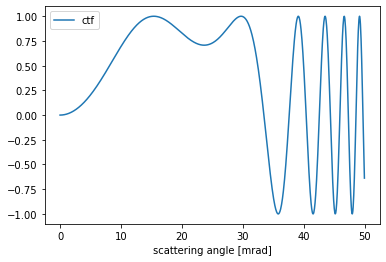

In [7]:
ctf.profiles(max_angle=50).show(units="mrad");

To perform the operation in Eq. {eq}`eq:user_guide:walkthrough:contrast_transfer_function:apply_ctf`, we use the `apply_ctf` method.

In [8]:
image_wave = exit_wave.apply_ctf(ctf)

We show the exit wave function and the wave function at image plane below.

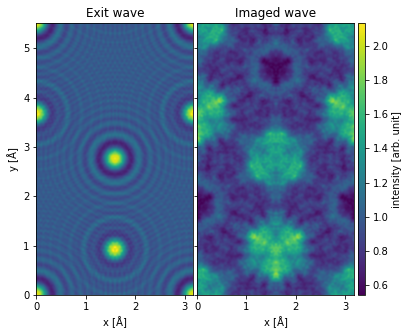

In [9]:
abtem.stack([exit_wave, image_wave], ("Exit wave", "Imaged wave")).show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

### Focal series

As we should expect, the aberrations may be given as a distribution. This is useful for simulating focal series and for simulating batches of images, in the very common case where exact values of the aberrations are unknown.

In [10]:
ctf_series = abtem.CTF(Cs=-25e-6 * 1e10, energy=80e3)

ctf_series.defocus = abtem.distributions.uniform(0, 1 * ctf_series.scherzer_defocus, 5)

When this `CTF` is applied to the wave function we obtain an ensemble of wave functions.

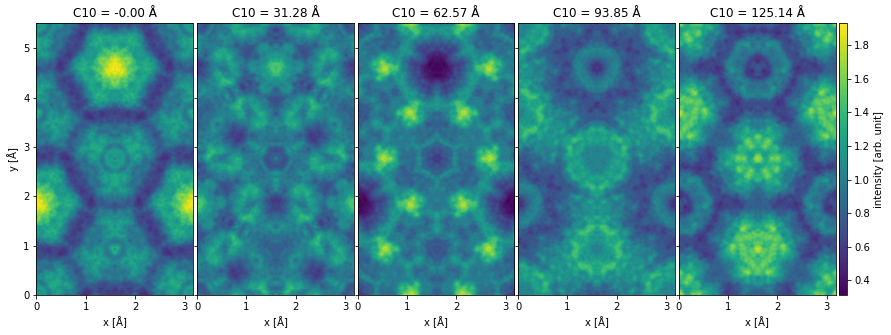

In [11]:
waves_image_series = exit_wave.apply_ctf(ctf_series)

waves_image_series.show(
    figsize=(18, 5),
    cbar=True,
    explode=True,
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
);

## Aperture

The maximum transferred frequency is limited by the aperture of the objective lens. This is conventionally described as a multiplication with the aperture function. 

$$
    \psi_{\mathrm{image}}(k, \phi) = A(k) \exp[-i \chi(k, \phi)] \psi_{\mathrm{exit}}(k, \phi)
$$

where $A(k)$ is the aperture function

$$
    A(k) = \begin{cases} 1 & \text{if } x \geq k_{cut} \\ 0 & \text{if } x < k_{cut} \end{cases} .
$$

We will cut off the `CTF` at the angle corresponding to the Scherzer [point resolution](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus), which is defined as the angle where the phase of the `CTF` crosses the abscissa for the first time.

In [12]:
ctf_cutoff = ctf.copy()

ctf_cutoff.semiangle_cutoff = ctf_cutoff.crossover_angle

print(f"cutoff = {ctf_cutoff.crossover_angle:.3f} mrad")

cutoff = 33.455 mrad


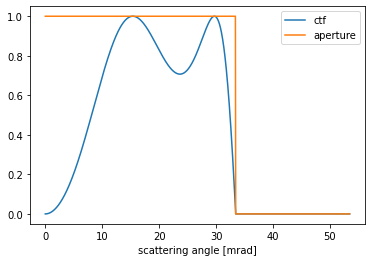

In [13]:
ctf_cutoff.profiles().show(units="mrad");

We show the resulting image below and see, as expected, that applying this aperture removes high-frequency information from the wave function intensity.

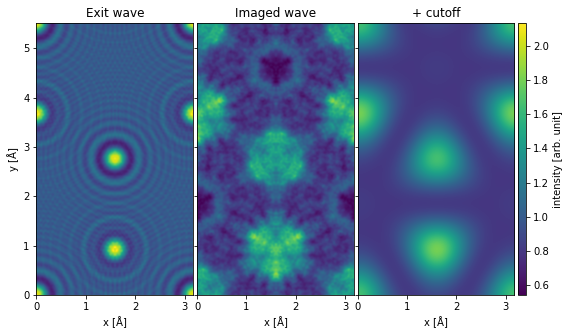

In [14]:
waves_cutoff = exit_wave.apply_ctf(ctf_cutoff)

abtem.stack(
    [exit_wave, image_wave, waves_cutoff], ("Exit wave", "Imaged wave", "+ cutoff")
).show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

## Partial coherence (quasi-coherent)
Partial coherence acts similarly to the aperture function to dampen the high spatial frequencies of the signal. Partial coherence may be approximated by multiplying the `CTF` by envelope functions.

$$
    \psi_{\mathrm{image}}(k, \phi) = \mathrm{CTF}(k, \phi) \psi_{\mathrm{exit}}(k, \phi)
$$

where the contrast transfer function is given as

$$
    \mathrm{CTF}(k, \phi) = E_t(k) E_s(k) A(k) \exp[-i \chi(k, \phi)]
$$

and $E_t(k)$ and $E_s(k)$, to be defined below are the temporal and spatial envelopes, respectively. 


```{warning}
Here partial coherence is applied using the convenient quasi-coherent approximation. This is only appropriate for HRTEM simulations when the effect is sufficiently small, it is generally never appropirate for STEM simulations. The more accurate approach of using an incoherent summation is introduced here.
```

#### Partial temporal coherence

The most important source of partial coherence in HRTEM is partial temporal coherence. A small spread in energy, $\Delta E$, of the incident electrons, due to the chromatic aberration of the objective lens, is equivalent to a small spread in defocus. Fluctuations in the focusing currents, $\Delta I$, of the objective lens also produce an incoherent spread in defocus. Combining these effects, the $1 / e$ width (here $e \approx 2.71828$ denotes the Euler number) of the distribution of defocus values (the focal spread) can be written as

$$
    \delta = C_c \sqrt{4 \left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}.
$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source. $C_c$ is the chromatic aberration coefficient. Assuming $\delta$ is small, it can be shown that the focal spread can be approximated as

$$
    E_t(k) = \exp\left[-\frac{1}{4} \left(\pi \lambda \delta \right)^2 k^4 \right] .
$$

The parameter $\delta$ above is equivalent to the `focal_spread` keyword and given in $\mathrm{Å}$.

We calculate a realistic value of the focal spread to $52.5 \ \mathrm{Å}$. This was calculated using an energy spread of $0.35 \ \mathrm{eV}$ and a chromatic aberration of $1.2 \ \mathrm{mm}$, which would be considered good for microscope with $C_c$-correction.

In [15]:
Cc = 1.2e-3 * 1e10
energy = exit_wave.energy
energy_spread = 0.35

focal_spread = Cc * energy_spread / energy

print(f"focal spread = {focal_spread:.2f} Å")

focal spread = 52.50 Å


We show a plot of the `CTF` below. Given this plot we may conclude that for a focal spread of this size the aperture have almost no effect as the envelope already goes to zero at the cutoff.

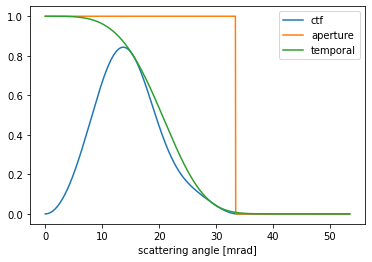

In [16]:
ctf_partial = ctf_cutoff.copy()
ctf_partial.focal_spread = focal_spread
ctf_partial.profiles().show(units="mrad");

#### Partial spatial coherence

As the electron source has a finite size, the incident beam contains a distribution of incident directions. In HRTEM this is quantified by the angular spread. Assuming that each incident direction performs its own scattering and that the distribution of incident directions is small, then it can be shown that the angular spread can be modelled by the spatial coherence envelope function, as given by

$$
    E_s(k) = \exp\left(-\frac{\beta}{4\lambda^2}\left| \frac{\partial \chi(k)}{\partial k}\right|^2  \right) .
$$

where $\beta$ is the $1/e$ width of the distribution of angles. The parameter $\beta$ is equivalent the `angular_spread` keyword and given in $\mathrm{mrad}$.

Given a modern electron source such as a field emmission gun, the partial spatial coherence is typically negligible, even in microscopes with chromatic aberration correction. 

Given an angular spread of $0.5 \ \mathrm{mrad}$, which would be considered large, we obtain the spatial envelope illustrated below. We see that the spatial envelope have almost no effect.

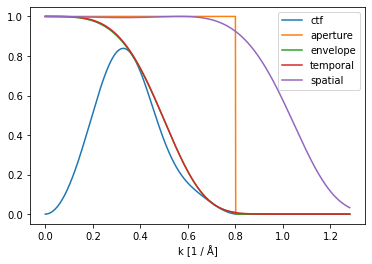

In [17]:
ctf_partial.angular_spread = 1

ctf_partial.profiles().show();

Finally we apply the `CTF` with the partial coherence envelope to the wave function. The effect is to further blur the image and to lower the contrast. 

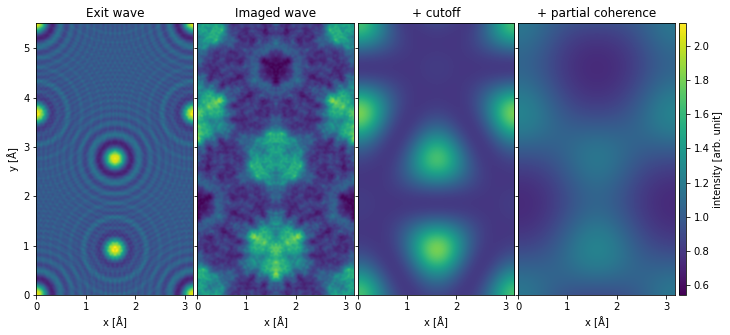

In [18]:
wave_partial = exit_wave.apply_ctf(ctf_partial)

abtem.stack(
    [exit_wave, image_wave, waves_cutoff, wave_partial],
    ("Exit wave", "Imaged wave", "+ cutoff", "+ partial coherence"),
).show(
    explode=True,
    figsize=(18, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

```{note}
Blurring can also be caused by noise leading to random deflection of the image relative to the detector, such as vibrations, drift of the stage and magnetic noise in the lenses. Such effects may be reasonably included by applying a gaussian blur.
```